In [2]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd 

In [3]:
train_dataset = MNIST( root='./data', train = True , download = True, transform = transforms.ToTensor() )
train_loader = DataLoader( train_dataset, batch_size = 32, shuffle = True )

test_dataset = MNIST( root='./data', train = False, download = False, transform = transforms.ToTensor() )
test_loader = DataLoader( test_dataset, batch_size = 32, shuffle = False )

RNN的输入: seq_len, batch_size, input_size( feature_len ) -> batch_size -> dim = 1, 用batch_first = True把batch_size调到最前面

In [4]:
class RNN_Model( nn.Module ):
    def __init__( self, input_dim, hidden_dim, layer_dim, output_dim ):
        super( RNN_Model, self ).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.RNN( input_dim, hidden_dim, layer_dim, batch_first = True, nonlinearity = 'relu' )
        self.fc = nn.Linear( hidden_dim, output_dim )
            
            
    def forward( self, x ):
        # 初始化隐藏层状态 -> layer_dim, batch_size, hidden_dim     x.size( 0 ) -> batch_size
        h0 = torch.zeros( self.layer_dim, x.size( 0 ), self.hidden_dim ).requires_grad_()
        out, hn = self.rnn( x, h0.detach() )                # 分离隐藏状态，避免梯度爆炸
        
        out = self.fc( out[ :, -1, : ] )                    # 只取最后一层隐藏层的状态
        return out

In [5]:
input_dim = 28          # 输入的图片都是28×28的
hidden_dim = 100        # 隐藏层的维度
# layer_dim = 2           # 2层RNN
output_dim = 10         # 输出维度 -> 一共有十种数字
seq_dim = 28            # 序列长度 -> 自己随便定义
'''


rnn = RNN_Model( input_dim, hidden_dim, layer_dim, output_dim )
loss_f = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD( rnn.parameters(), lr = 0.05 )
'''

'\n\n\nrnn = RNN_Model( input_dim, hidden_dim, layer_dim, output_dim )\nloss_f = nn.CrossEntropyLoss()\noptimizer = torch.optim.SGD( rnn.parameters(), lr = 0.05 )\n'

In [6]:
accuracy_list = []
'''
for epoch in range( 2 ):
    running_loss = 0.0
    for step, data in enumerate( train_loader, 0 ):
        img, label = data
        img = img.view( -1, seq_dim, input_dim ).requires_grad_()
        optimizer.zero_grad()
        output = rnn( img )
        loss = loss_f( output, label )
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if step % 500 == 499:
            r = 0
            total = 0
            for img, label in test_loader:
                with torch.no_grad():
                    img = img.view( -1, seq_dim, input_dim )    # 验证无需计算梯度
                    output = rnn( img )
                    pred = torch.max( output.data, 1 )[1]
                    total += label.size( 0 )                    # 统计测试集的大小
                    r += ( pred == label ).sum()
            acc = r / total
            accuracy_list.append( acc.item() )
            print( '[%d  %5d]   loss:%.3f   accuracy:%.3f' % (epoch + 1, step+1, running_loss / (step+1), acc) )
            running_loss = 0.0
'''              

"\nfor epoch in range( 2 ):\n    running_loss = 0.0\n    for step, data in enumerate( train_loader, 0 ):\n        img, label = data\n        img = img.view( -1, seq_dim, input_dim ).requires_grad_()\n        optimizer.zero_grad()\n        output = rnn( img )\n        loss = loss_f( output, label )\n        loss.backward()\n        optimizer.step()\n        running_loss += loss.item()\n        \n        if step % 500 == 499:\n            r = 0\n            total = 0\n            for img, label in test_loader:\n                with torch.no_grad():\n                    img = img.view( -1, seq_dim, input_dim )    # 验证无需计算梯度\n                    output = rnn( img )\n                    pred = torch.max( output.data, 1 )[1]\n                    total += label.size( 0 )                    # 统计测试集的大小\n                    r += ( pred == label ).sum()\n            acc = r / total\n            accuracy_list.append( acc.item() )\n            print( '[%d  %5d]   loss:%.3f   accuracy:%.3f' % (epoch

In [7]:
class LSTM_Model( nn.Module ):
    def __init__( self, input_dim, hidden_dim, layer_dim, output_dim ):
        super( LSTM_Model, self ).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM( input_dim, hidden_dim, layer_dim, batch_first = True )
        self.fc = nn.Linear( hidden_dim, output_dim )
            
            
    def forward( self, x ):
        # 初始化隐藏层状态 -> layer_dim, batch_size, hidden_dim     x.size( 0 ) -> batch_size
        h0 = torch.zeros( self.layer_dim, x.size( 0 ), self.hidden_dim ).requires_grad_()
        c0 = torch.zeros( self.layer_dim, x.size( 0 ), self.hidden_dim ).requires_grad_()
        
        out, ( hn, cn ) = self.lstm( x, ( h0.detach(), c0.detach() ) )                # 分离隐藏状态，避免梯度爆炸
        
        out = self.fc( out[ :, -1, : ] )                            # 只取最后一层隐藏层的状态
        return out

In [8]:
layer_dim = 1

lstm = LSTM_Model( input_dim, hidden_dim, layer_dim, output_dim )
loss_f = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD( lstm.parameters(), lr = 0.05 )


for epoch in range( 5 ):
    lstm.train()
    running_loss = 0.0
    for step, data in enumerate( train_loader, 0 ):
        img, label = data
        img = img.view( -1, seq_dim, input_dim ).requires_grad_()
        optimizer.zero_grad()
        output = lstm( img )
        loss = loss_f( output, label )
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if step % 500 == 499:
            lstm.eval()
            r = 0
            total = 0
            for img, label in test_loader:
                with torch.no_grad():
                    img = img.view( -1, seq_dim, input_dim )    # 验证无需计算梯度
                    output = lstm( img )
                    pred = torch.max( output.data, 1 )[1]
                    total += label.size( 0 )                    # 统计测试集的大小
                    r += ( pred == label ).sum()
            acc = r / total
            accuracy_list.append( acc.item() )
            print( '[%d  %5d]   loss:%.3f   accuracy:%.3f' % (epoch + 1, step+1, running_loss / (step+1), acc) )
            running_loss = 0.0
                

[1    500]   loss:2.299   accuracy:0.130
[1   1000]   loss:1.140   accuracy:0.177
[1   1500]   loss:0.695   accuracy:0.384
[2    500]   loss:0.889   accuracy:0.780
[2   1000]   loss:0.305   accuracy:0.857
[2   1500]   loss:0.152   accuracy:0.893
[3    500]   loss:0.286   accuracy:0.934
[3   1000]   loss:0.120   accuracy:0.918
[3   1500]   loss:0.070   accuracy:0.950
[4    500]   loss:0.176   accuracy:0.955
[4   1000]   loss:0.078   accuracy:0.958
[4   1500]   loss:0.050   accuracy:0.964
[5    500]   loss:0.135   accuracy:0.967
[5   1000]   loss:0.058   accuracy:0.967
[5   1500]   loss:0.036   accuracy:0.965


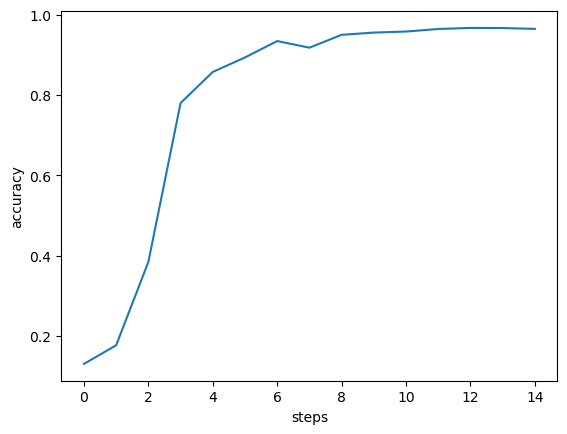

In [9]:
import matplotlib.pyplot as plt
step_list = [ i for i in range( len( accuracy_list ) ) ]
plt.plot( step_list, accuracy_list )
plt.xlabel('steps')
plt.ylabel('accuracy')
plt.show()


In [10]:
torch.save( lstm.state_dict(), '../path/LSTM.pth' )

识别数字：3


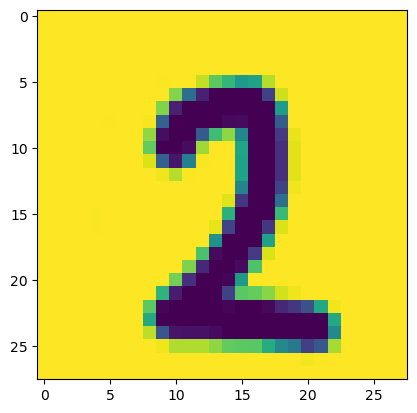

In [15]:
from PIL import Image
transform = transforms.ToTensor()

img = Image.open( './data/test6.jpg' )
img = img.resize( ( 28, 28 ) )
img = img.convert( 'L' )                        # 灰度
img = transforms.ToTensor()( img )
img = img.view( 1, 28, 28 )

output =lstm( img )
pred = torch.max( output.data, dim = 1 )[1]
print( '识别数字：%d' % pred.item() )
plt.imshow( img.squeeze() )
plt.show()